# Quantum NLP using the Quantum Trainer

In [2]:
!pip install pandas


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
import numpy as np

BATCH_SIZE = 5
EPOCHS = 6
SEED = 2
len_dataset = 100

In [5]:
import pandas as pd
df = pd.read_csv('MC1.TXT', header=None)
df.head(2)

,0,1,2
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1


In [6]:
df.rename(columns = {0:'sentence1', 1:'sentence2', 2:'label'}, inplace = True)

df.to_csv('dataset2.csv', index=None)

### Read in the data and create diagrams

In [7]:
train_split = int(len_dataset * 0.8)
val_split = int(len_dataset * 0.9)
test_split = int(len_dataset)

df = pd.read_csv('dataset2' + '.csv')
df.head()
df_negative = df[df['label'] == 0]
df_positive = df[df['label'] == 1]

df_positive = df_positive[:int(len_dataset * 0.53)]
df_negative = df_negative[:int(len_dataset * 0.47)]

df_final = pd.concat([df_positive, df_negative])

data1 = list(df_final['sentence1'])
data2 = list(df_final['sentence2'])
data = df_final['sentence1'] +' '+ df_final['sentence2']
data =list(data)
labels_raw = list(df_final['label'])

labels = [[x, 1-x] for x in labels_raw]

train_data = data[:train_split]
dev_data = data[train_split:val_split]
test_data = data[val_split:test_split]

train_labels = labels[:train_split]
dev_labels = labels[train_split:val_split]
test_labels = labels[val_split:test_split]

### Create diagrams

In [8]:
!pip install cirq


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [9]:
!pip install lambeq


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [10]:
from lambeq import BobcatParser

In [11]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove the cups

In [ ]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

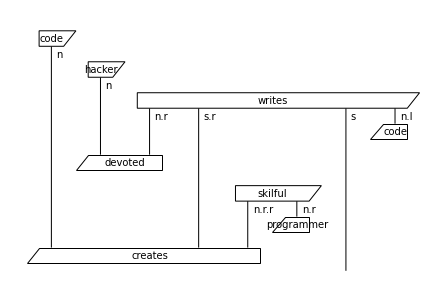

In [13]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[1].draw()

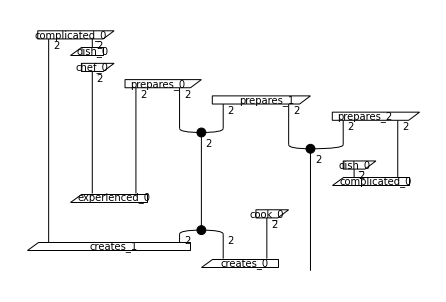

In [14]:
from discopy import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

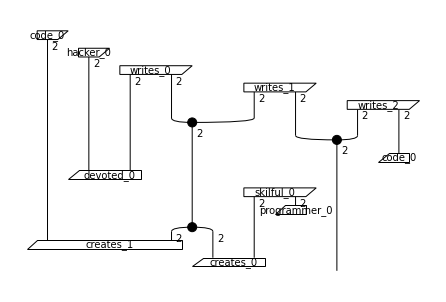

In [15]:
from discopy import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[1].draw()

### Create circuits

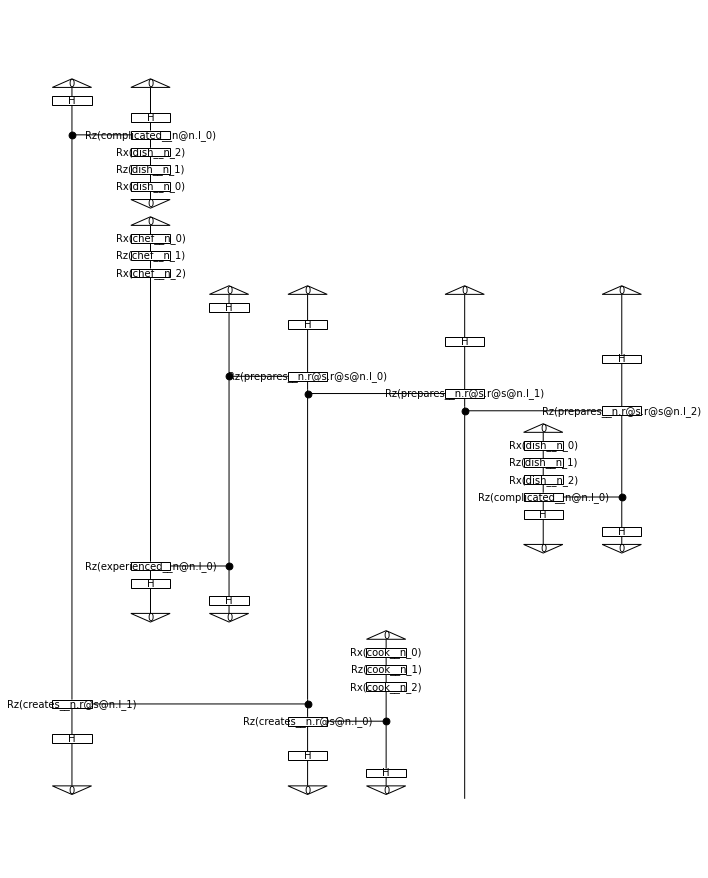

In [16]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

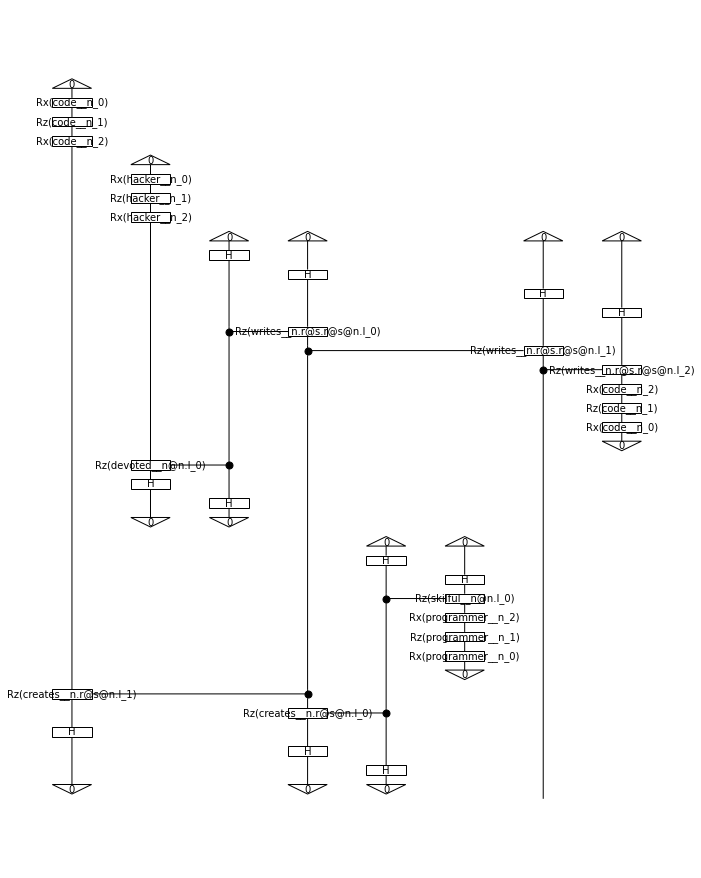

In [17]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[1].draw(figsize=(9, 12))

In [18]:
!pip install pytket-qiskit


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


### Parameterise

In [19]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots':8192 
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

### Define evaluation metric

In [20]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [21]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [22]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [23]:
trainer.fit(train_dataset, val_dataset, logging_step=2)

Epoch 1:  train/loss: 3.0310   valid/loss: 1.9455   train/acc: 0.5250   valid/acc: 0.5000
Epoch 2:  train/loss: 3.1739   valid/loss: 0.4504   train/acc: 0.4938   valid/acc: 0.7000
Epoch 4:  train/loss: 2.8877   valid/loss: 3.3660   train/acc: 0.5500   valid/acc: 0.4500
Epoch 6:  train/loss: 2.4876   valid/loss: 4.8485   train/acc: 0.4750   valid/acc: 0.5000

Training completed!


### Show results

Test accuracy: 0.5


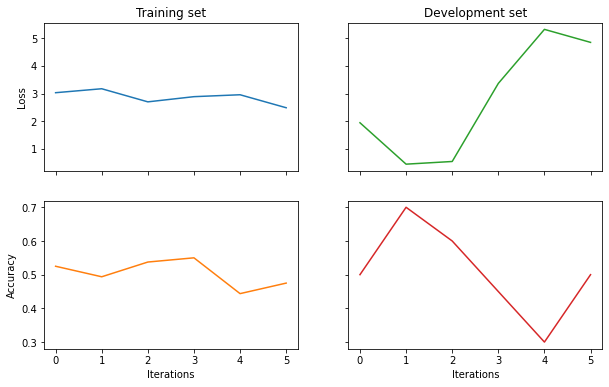

In [24]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)